In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from PIL import Image
import numpy as np

df = pd.read_csv('./data/metadata.csv')

In [2]:
print(df['label'].groupby(df['label']).count())
print("Clean is 0\nDirty is 1")

label
0    113
1    124
Name: label, dtype: int64
Clean is 0
Dirty is 1


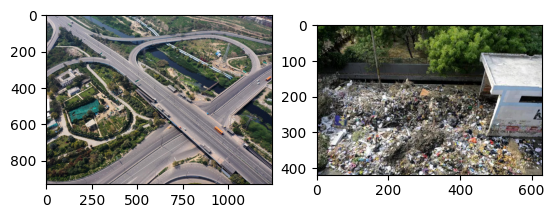

In [3]:
import random
clean_img = np.asarray(Image.open(f'./data/Images/clean_{random.randint(1, 113)}.jpg'))
dirty_img = np.asarray(Image.open(f'./data/Images/dirty_{random.randint(1, 113)}.jpg'))

fig, axs = plt.subplots(1,2)
axs[0].imshow(clean_img)
axs[1].imshow(dirty_img)


In [4]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [5]:
import os
from torch.utils.data import Dataset

class RoadCleanlinessDataset(Dataset):
    """Road Cleanliness dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.target = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.target.iloc[idx, 0])
        image = np.array(Image.open(img_name))
        if image.shape[2] > 3:
            image = np.array(Image.open(img_name).convert('RGB'))
        label = self.target.iloc[idx, 1]
        sample = (image, np.array(label))

        if self.transform:
            sample = self.transform(sample)

        return sample

In [6]:
dataset = RoadCleanlinessDataset('./data/metadata.csv', './data/Images/')

In [8]:
for i in range(len(dataset)):
    sample = dataset[i]
    if sample[0].shape[2] != 3: 
        print(i, sample[0].shape, sample[1])

0 (297, 400, 3) 1
1 (720, 1280, 3) 0
2 (485, 726, 3) 0
3 (2667, 2532, 3) 1


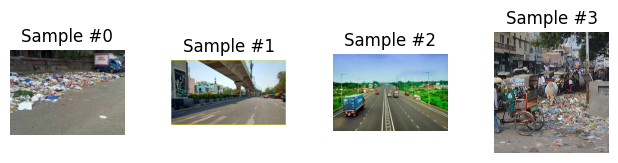

In [10]:
fig = plt.figure()

for i in range(len(dataset)):
    image, label = dataset[i]

    print(i, image.shape, label)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(image)

    if i == 3:
        plt.show()
        break

In [28]:
from torchvision.transforms import Compose
from skimage import transform

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h = int(new_h)
        new_w = int(new_w)
        img = transform.resize(image, (new_h, new_w))

        return (img, label)

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return (torch.from_numpy(image).to(torch.float32),
                torch.from_numpy(label).to(torch.float32))

transformation = Compose([
    Rescale((256,256)),
    ToTensor()
])

dataset = RoadCleanlinessDataset('./data/metadata.csv', './data/Images/', transform=transformation)


0 torch.Size([4, 3, 256, 256]) torch.Size([4])
1 torch.Size([4, 3, 256, 256]) torch.Size([4])
2 torch.Size([4, 3, 256, 256]) torch.Size([4])
3 torch.Size([4, 3, 256, 256]) torch.Size([4])


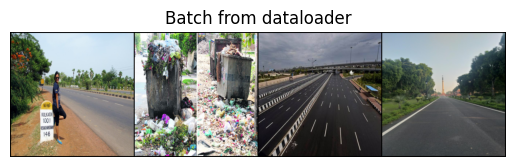

In [29]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

dataloader = DataLoader(dataset, batch_size=4,
                        shuffle=True, num_workers=0)

def show_roads_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched[0], sample_batched[1]
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.title('Batch from dataloader')


for i_batch, (image, label) in enumerate(dataloader):
    print(i_batch, image.size(),
          label.size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_roads_batch((image, label))
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [52]:
import torch.nn as nn
import torch.nn.functional as F

# Define the model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # L1 ImgIn shape=(?, 256, 256, 3)
        # Conv -> (?, 256, 256, 32)
        # Pool -> (?, 128, 128, 32)
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, 5, dtype=torch.float32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # L2 ImgIn shape=   (?, 128, 128, 32)
        # Conv      ->      (?, 128, 128, 64)
        # Pool      ->      (?, 64, 64, 64)
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # L3 ImgIn shape=   (?, 64, 64, 64)
        # Conv      ->      (?, 64, 64, 128)
        # Pool      ->      (?, 32, 32, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        )
        # L4 ImgIn shape=   (?, 32, 32, 128)
        # Conv      ->      (?, 32, 32, 256)
        # Pool      ->      (?, 16, 16, 256)
        self.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        )
        # L5 ImgIn shape=   (?, 16, 16, 256)
        # Conv      ->      (?, 16, 16, 512)
        # Pool      ->      (?, 8, 8, 512)
        self.layer5 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        )
        # L6 FC 8*8*512 inputs -> 32768 outputs
        self.fc1 = nn.Linear(8*8*512, 32768, bias=True)
        # L7 Final FC 131,072 inputs -> 10 outputs
        self.fc2 = torch.nn.Linear(32768, 1, bias=True)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# Create the model
model = CNN()

In [53]:
from torch import optim
num_epochs = 1
# Set the model to train mode
model.train()

# Set the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Set the loss function
criterion = nn.CrossEntropyLoss()

# Train the model
for epoch in range(num_epochs):
    for batch_idx, (image, label) in enumerate(dataloader):
        # Clear the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(image)
        
        #print(output.shape)
        # Calculate the loss
        loss = criterion(output, label)
        
        # Backward pass
        loss.backward()
        
        # Update the parameters
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if batch_idx % 200 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, batch_idx + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x41472 and 32768x32768)

In [61]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data['image']
        labels = data['label']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.to(torch.float32))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x59536 and 400x120)